In [9]:
import sys
sys.path.insert(0, '../../_libs/')
import NEMO_tools as Nts

In [10]:
import glob
import datetime
import scipy.io
import numpy as np
#import seaborn as sb
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.signal import detrend
import matplotlib.patches as mpatches
from mpl_toolkits.basemap import Basemap, cm
% matplotlib inline

In [11]:
#sb.set_style('none')

In [12]:
RB=[0.25, 0.41, 0.88]    # Royal blue
AM=[0.90, 0.17, 0.31]    # Amathran
SB=[0.06, 0.05, 0.03]    # Smokey Black
AFB = [0.36, 0.54, 0.66] # Air Force Blue
AG = [0.55, 0.71, 0.0]   # Apple Green
AZ = [0.0, 0.5, 1.0]     # Azure
CB = [0.37, 0.62, 0.63]  # Cadet blue
SP = [1.0, 0.72, 0.77]   # Sakura
CamB = [0.64, 0.76, 0.68]# Cambridge blue
DC = [0.0, 0.55, 0.55]   # Dark cyan
DE = [0.08, 0.38, 0.74]  # Denim
BB = [0.54, 0.81, 0.94]  # Baby blue

In [13]:
Mon = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [14]:
def seasonal_cycle(data):
    out = np.empty([12, np.size(data, 1), np.size(data, 2)])
    for mon in range(12):
        out[mon, :, :] = np.nanmean(data[mon:len(data):12, :, :], 0)
    return out
def seasonal_decomp3d(data):
    anom = np.empty(data.shape)
    for mon in range(12):
        temp_data = np.nanmean(data[mon:len(data):12, :, :], 0)
        anom[mon:len(data):12, :, :] = data[mon:len(data):12, :, :]-temp_data
    return anom
def monmean_3d(data):
    monmean=np.zeros([12, np.size(data, axis=1), np.size(data, axis=2)])
    for mon in range(12):
        monmean[mon, :, :] = np.nanmean(data[mon:len(data):12, :, :], 0)
    return monmean

In [15]:
ETOPO2_Arctic=scipy.io.loadmat('../../_libs/ETOPO2_Arctic.mat')
lon_arctic=ETOPO2_Arctic['lon_arctic']
lat_arctic=ETOPO2_Arctic['lat_arctic']
topo_arctic=ETOPO2_Arctic['topo_arctic']
#
res_unit=5
lon_arctic=lon_arctic[0:-1:res_unit, 0:-1:res_unit]
lat_arctic=lat_arctic[0:-1:res_unit, 0:-1:res_unit]
topo_arctic=topo_arctic[0:-1:res_unit, 0:-1:res_unit]*-1

In [16]:
ice_name = '/ocean/yingkai/GEOTRACES/FORCING/ANHA4/ileadfra_monmean.nc'
ice_obj = nc.Dataset(ice_name)
ice = ice_obj.variables['ileadfra'][:]
ice_monmean = monmean_3d(ice)
ice_sep = ice_monmean[8, :, :]
id_ice = ice_sep > 0.7
#id_ice_reverse = ice_sep <= 0.7

/homes/anu/yingkai/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater


In [17]:
sss_name = '/ocean/yingkai/GEOTRACES/FORCING/ANHA4/isssalin_monmean.nc'
sss_obj = nc.Dataset(sss_name)
sss = sss_obj.variables['isssalin'][:]

In [18]:
FName = '/ocean/yingkai/GEOTRACES/Simulations/BASE03_1m_20020101_20131231_ptrc_T.nc'

In [19]:
ptrc_obj = nc.Dataset(FName)
d18O = np.squeeze(ptrc_obj.variables['d18O'][:, 0, :, :])
Ba = np.squeeze(ptrc_obj.variables['Ba'][:, 0, :, :])
d18O[Ba==0]=np.nan
#d18O = np.nanmean(d18O, 1) 
d18O[:, ~id_ice]=np.nan
d18O_all = np.squeeze(ptrc_obj.variables['d18O'][:, 0, :, :])
d18O_all[Ba==0]=np.nan
nav_lat = ptrc_obj.variables['nav_lat'][:]
nav_lon = ptrc_obj.variables['nav_lon'][:]
deptht = ptrc_obj.variables['deptht'][:]

In [20]:
#MAT = scipy.io.loadmat('../../_data/Exchange/dtrend_d18O.mat')
#d18O = MAT['dtrend_d18O'][:]

In [21]:
#d18O_anom = seasonal_decomp3d(d18O)
d18O_monmean = seasonal_cycle(d18O)
d18O_monmean_all = seasonal_cycle(d18O_all)

/home/yingkai/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [22]:
d18O_compare = np.nanmean(d18O_monmean, 0)
d18O_compare = d18O_compare[Ba[0, :, :]>0]
sss_compare = np.nanmean(sss, 0)
sss_compare = sss_compare[Ba[0, :, :]>0]

In [40]:
sss_compare = sss_compare[~np.isnan(d18O_compare)]
d18O_compare = d18O_compare[~np.isnan(d18O_compare)]

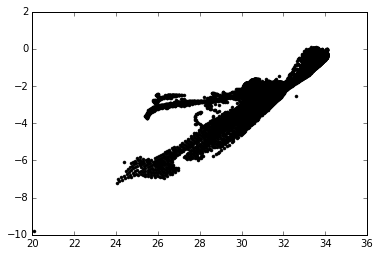

In [23]:
plt.plot(sss_compare, d18O_compare, 'k.')

In [110]:
def hist2dxy(hist_x, hist_y, Xnum, Ynum, clevs, CMap=plt.cm.gist_ncar_r):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    Xlim=[np.nanmin(hist_x), np.nanmax(hist_x)]
    Xbins=np.linspace(25, 34.5, Xnum, dtype=np.float)
    Ylim=[np.nanmin(hist_y), np.nanmax(hist_y)]
    Ybins=np.linspace(-7.5, 0.5, Ynum, dtype=np.float)
    #print(Ybins)
    H, y_edges, x_edges = np.histogram2d(hist_y, hist_x, bins=(Ybins, Xbins))
    X, Y = np.meshgrid(x_edges[:-1], y_edges[:-1])
    # set axis
    left=0.1; width = 0.8; bottom=0.1; height = 0.65
    gap=0.02; hist_len=0.2; cbar_len=0.12
    # three boxes
    rect_main  = [left+hist_len+gap, bottom, width, height]
    rect_histx = [left+hist_len+gap, left+height+gap, width-cbar_len, hist_len]
    rect_histy = [left, bottom, hist_len, height]
    # x, y limits
    xlim_bin=[25, 34.5]
    ylim_bin=[-7.5, 0.5]
    # ========== figure ========== #
    fig=plt.figure(figsize=(9, 9))
    # ========== Main ========== #
    # axis
    axMain=plt.axes(rect_main)
    axMain.yaxis.tick_right()
    axMain.yaxis.set_label_position('right')
    axMain.set_xlim(xlim_bin)
    axMain.set_ylim(ylim_bin)
    divider=make_axes_locatable(axMain)
    # grid and frame
    axMain.grid() # grid on
    
    #axMain.plot(hist_x, hist_y, 'k.', alpha=0.1)
    
    [i.set_linewidth(2) for i in axMain.spines.itervalues()] # a bold frame
    CS=axMain.contourf(X, Y, H, clevs, cmap=CMap, extend='max') # 2-D histgram
    axMain.contour(X, Y, H, [0], colors=('gray',), linewidths=0.5)
    CAx=divider.append_axes('right', size='5%', pad=0.75)
    CBar=plt.colorbar(CS, cax=CAx)
    CBar.set_label('Number of points', fontsize=14)
    CBar.ax.tick_params(axis='y', length=22.5)
    # ========== Hist-x ========== #
    axHistx=plt.axes(rect_histx)
    axHistx.hist(hist_x, bins=Xbins, color='gray')
    axHistx.set_xlim(Xlim)
    axHistx.axes.get_xaxis().set_visible(False)
    # scientific notation for x, y-axis
    plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    [i.set_linewidth(2) for i in axHistx.spines.itervalues()]
    axHistx.grid()
    # ========== Hist-y ========== #
    axHisty = plt.axes(rect_histy)
    axHisty.hist(hist_y, bins=Ybins, color='gray', orientation='horizontal')
    axHisty.set_ylim(Ylim)
    axHisty.invert_xaxis()
    axHisty.axes.get_yaxis().set_visible(False)
    plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    [i.set_linewidth(2) for i in axHisty.spines.itervalues()]
    axHisty.grid()
    return fig, axMain, axHistx, axHisty

In [111]:
sss_compare.max()

34.091070884186415

In [112]:
clevs=[1, 3, 5, 10, 15, 20, 25, 30, 35, 50, 65]

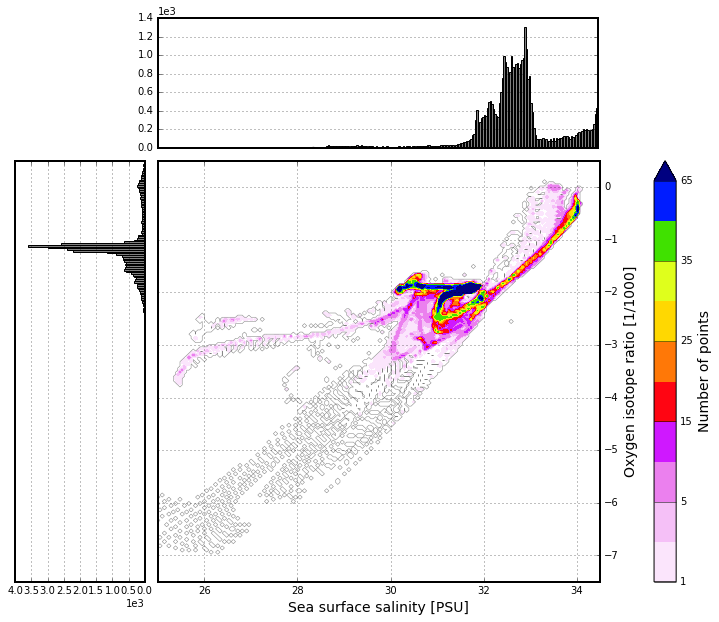

In [114]:
fig, axMain, axHistx, axHisty = hist2dxy(sss_compare, d18O_compare, 200, 200, clevs, CMap=plt.cm.gist_ncar_r)
axMain.set_ylabel('Oxygen isotope ratio [1/1000]', fontsize=14)
axMain.set_xlabel('Sea surface salinity [PSU]', fontsize=14)

In [16]:
d18O_t = np.nanmean(np.nanmean(d18O, 1), 1)
d18O_stack = np.reshape(d18O_t, [12, 12])
d18O_stack_min = np.min(d18O_stack, 0)
d18O_stack_mean = np.mean(d18O_stack, 0)
d18O_stack_max = np.max(d18O_stack, 0)
fake_x = range(1, 13)

In [255]:
from dateutil.relativedelta import relativedelta

base = datetime.datetime(2001, 1, 1)
date_list = [base + relativedelta(months=x) for x in range(168)]

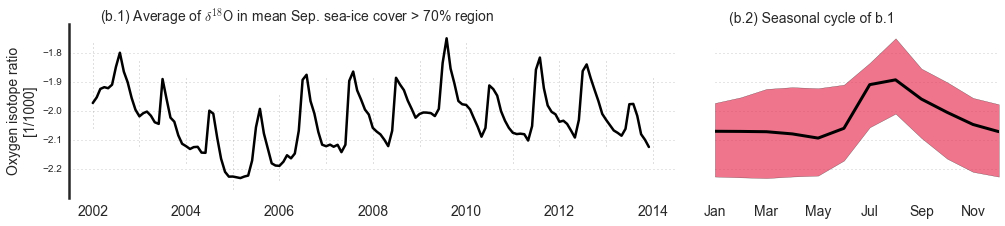

In [321]:
fig = plt.figure(figsize=(13.6, 3))

ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid((1, 3), (0, 2), colspan=1, rowspan=1)
fig.tight_layout()
fig.subplots_adjust(hspace=0.01)
AX = [ax1, ax2]
for i in range(2):
    AX[i].grid(linestyle=':')
    AX[i].xaxis.grid(False)
    AX[i].spines["top"].set_visible(False)
    AX[i].spines["bottom"].set_visible(False) 
    AX[i].spines["right"].set_visible(False)
    AX[i].xaxis.set_tick_params(labelsize=14)
    [j.set_linewidth(2.5) for j in AX[i].spines.itervalues()]
    
ax1.set_yticks(np.arange(-2.2, -1.8, 0.1)); ax1.set_ylim([-2.3, -1.7])
ax1.set_ylabel('Oxygen isotope ratio\n[1/1000]', fontsize=14)
ax1.set_xlim([date_list[6], date_list[-6]])
ax1.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")

for i in [12, 108]:
    ax1.axvline(date_list[i], ymin=0.4, ymax=0.9, lw=0.5, ls=':', color='gray')
for i in [24, 96, 132, 144]:
    ax1.axvline(date_list[i], ymin=0.3, ymax=0.8, lw=0.5, ls=':', color='gray')
for i in [36, 72, 84, 120, 156]:
    ax1.axvline(date_list[i], ymin=0.2, ymax=0.7, lw=0.5, ls=':', color='gray')  
for i in [60]:
    ax1.axvline(date_list[i], ymin=0.1, ymax=0.6, lw=0.5, ls=':', color='gray') 
for i in [48]:
    ax1.axvline(date_list[i], ymin=0.05, ymax=0.5, lw=0.5, ls=':', color='gray')   
    
    
ax2.spines["left"].set_visible(False)
ax2.set_yticks(np.arange(-2.2, -1.8, 0.1)); ax2.set_ylim([-2.3, -1.7])
ax2.set_xlim([1, 12]); ax2.set_xticks(fake_x[::2]); ax2.set_xticklabels(Mon[::2])
ax2.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="off")

#patch = mpatches.Patch(color=RB, alpha=0.65, label="muti-year min/max")
#legend_handle = plt.legend(handles=[patch], bbox_to_anchor=(1.05, 1), frameon=False, prop={'size':12})
#ax2.add_artist(legend_handle)

ax1.plot(date_list[12:-12], d18O_t, '-', color='k', lw=2.5)
ax1.set_title('(b.1) Average of $\mathsf{\delta^{18}O}$ in mean Sep. sea-ice cover > 70% region', x=0.05, y=0.98, loc='left', fontsize=14)
ax2.fill_between(fake_x, d18O_stack_min, d18O_stack_max, facecolor=AM, edgecolor=None, interpolate=True, alpha=0.65)
ax2.plot(fake_x, d18O_stack_mean, color='k', lw=3)
ax2.set_title('(b.2) Seasonal cycle of b.1', x=0.05, y=0.98, loc='left', fontsize=14)

fig.savefig('../../d18O_Part2.png', dpi=300, orientation='portrait', papertype='a4', format='png',
                bbox_inches='tight', pad_inches=0.1)

In [121]:
lev1 = np.array([-5, -4, -3.5, -3, -2.5, -2, -1.5, -1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5])

In [234]:
lev2 = np.array([-9, -7, -5, -3, -1, 1, 3, 5, 7, 9])/10.0

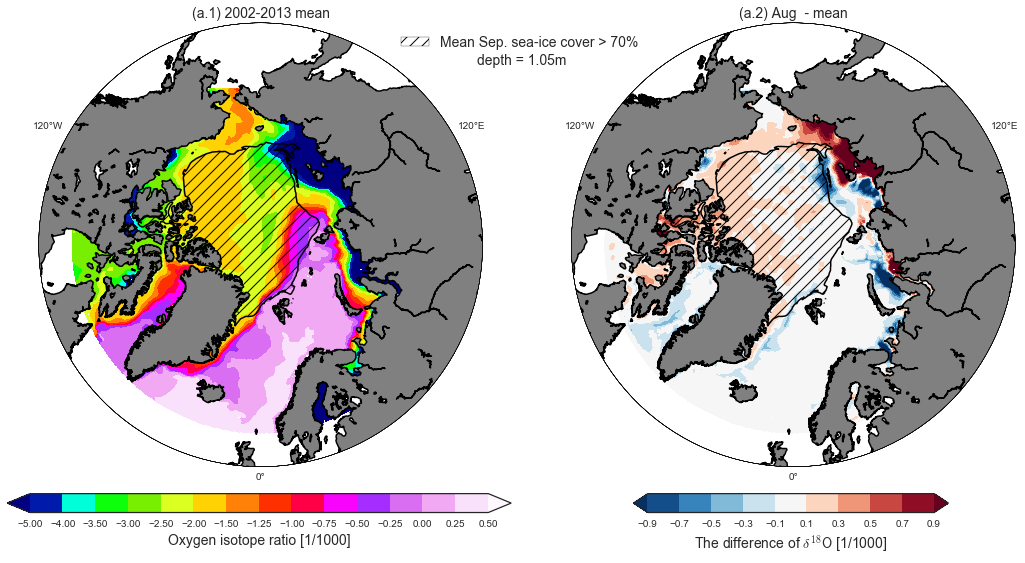

In [335]:
fig=plt.figure(figsize=(17.5, 17.5));

ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
#ax = fig.gca()

proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=0, round=True, ax=ax1)
proj.drawmeridians(np.arange(0, 360, 120), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
x, y=proj(nav_lon, nav_lat)

CS1 = proj.contourf(x, y, np.nanmean(d18O_monmean_all, 0), lev1, cmap=plt.cm.gist_ncar, extend='both')
proj.contour(x, y, ice_sep*100, [70], colors=('k',), linewidths=1.5, zorder=4)
proj.contourf(x, y, ice_sep*100, [70, 100], hatches=['//', ' '], colors='none', zorder=4)
ax1.set_title('(a.1) 2002-2013 mean', fontsize=14)

proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=0, round=True, ax=ax2)
proj.drawmeridians(np.arange(0, 360, 120), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
x, y=proj(nav_lon, nav_lat)
CS2 = proj.contourf(x, y, d18O_monmean_all[7, :, :]-np.nanmean(d18O_monmean_all, 0), lev2, cmap=plt.cm.RdBu_r, extend='both')
proj.contour(x, y, ice_sep*100, [70], colors=('k',), linewidths=1.5, zorder=4)
CS3 = proj.contourf(x, y, ice_sep*100, [70, 100], hatches=['//', ' '], colors='none', zorder=4)
ax2.set_title('(a.2) Aug  - mean', fontsize=14)

artists, _ = CS3.legend_elements()
labels = ['Mean Sep. sea-ice cover > 70%']
ax1.legend(artists, labels, bbox_to_anchor=(1.38, 1), prop={'size':14})
cax = fig.add_axes([0.1, 0.3, 0.4, 0.015])
CBar = fig.colorbar(CS1, cax=cax, orientation='horizontal')
CBar.set_label('Oxygen isotope ratio [1/1000]', fontsize=14)
CBar.ax.tick_params(axis='x', length=0)
CBar.set_ticks(lev1)

cax = fig.add_axes([0.597, 0.3, 0.25, 0.015])
CBar = fig.colorbar(CS2, cax=cax, orientation='horizontal')
CBar.set_label('The difference of $\mathsf{\delta^{18}O}$ [1/1000]', fontsize=14)
CBar.ax.tick_params(axis='x', length=0)
CBar.set_ticks(lev2)

ax1.text(8.75e6, 7.35e6, 'depth = 1.05m',
        horizontalalignment='center',
        verticalalignment='center', fontsize=14)

fig.savefig('../../d18O_Part1.png', dpi=300, orientation='portrait', papertype='a4', format='png',
                bbox_inches='tight', pad_inches=0.1)

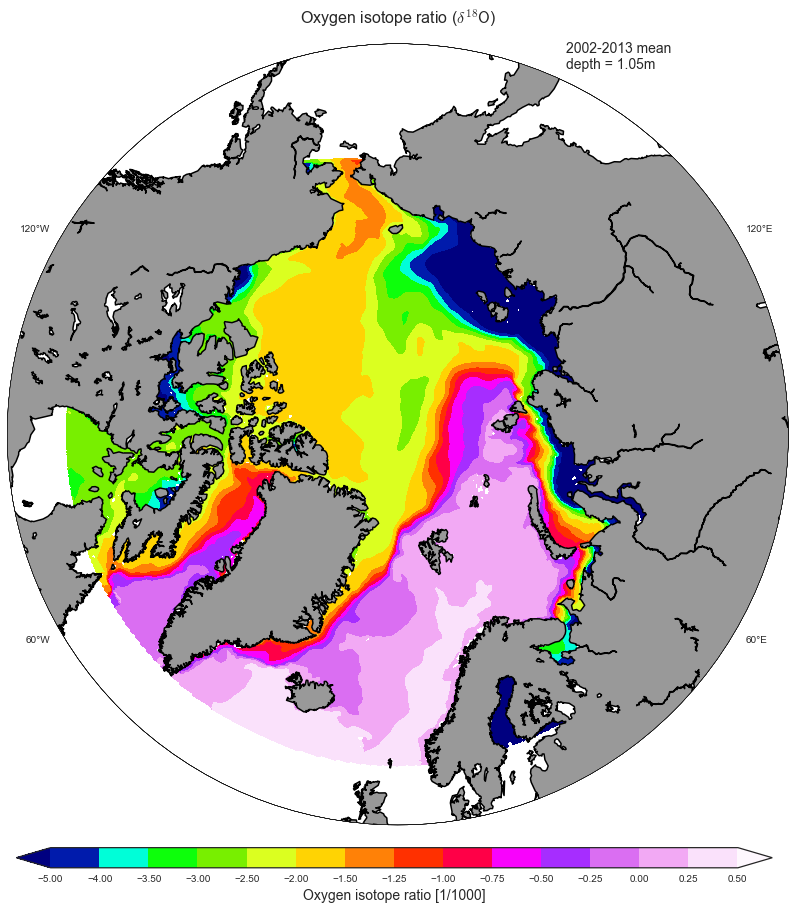

In [377]:
fig=plt.figure(figsize=(14, 14));
ax = fig.gca()

proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=0, round=True, ax=ax)
proj.drawmeridians(np.array([60, 120, 240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color='0.6', lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
x, y=proj(nav_lon, nav_lat)

CS1 = proj.contourf(x, y, np.nanmean(d18O_monmean_all, 0), lev1, cmap=plt.cm.gist_ncar, extend='both')

ax.set_title('Oxygen isotope ratio ($\mathsf{\delta^{18}O}$)', fontsize=16, y=1.02)

ax.text(5.75e6, 7.9e6, '2002-2013 mean\ndepth = 1.05m',
        horizontalalignment='left',
        verticalalignment='center', fontsize=14)

cax = fig.add_axes([0.134, 0.0825, 0.75, 0.02])
CBar = fig.colorbar(CS1, cax=cax, orientation='horizontal')
CBar.set_label('Oxygen isotope ratio [1/1000]', fontsize=14)
CBar.ax.tick_params(axis='x', length=0)
CBar.set_ticks(lev1)

fig.savefig('../../d18O_mean.png', dpi=250, orientation='portrait', papertype='a4', format='png',
                bbox_inches='tight', pad_inches=0.1)